In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from pymongo import MongoClient
from time import time
from collections import Counter
from textblob import TextBlob
import pandas as pd
import numpy as np
import re
import os

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# default plot stying changes
import seaborn as sns
sns.set_style("white")
sns.set_context("poster", font_scale=1.25, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
colors = sns.color_palette('Set2',12)

# Credentials

In [2]:
pw_file = 'pw.txt'
if os.path.exists(pw_file): 
    with open(pw_file, 'r') as f:
        email, indeed_pw = f.readline().strip().split(', ')
        username, pia_pw = f.readline().strip().split(', ')
        pub_ip, mongo_usr, mongo_usr_pw = f.readline().strip().split(', ')

# Connect to DB

In [3]:
# connect to ec2 mongo client
client = MongoClient('{0}:27017'.format(pub_ip))

In [4]:
# get reference to  resume_db
db = client.resume_db

In [5]:
# authenticate user for database
db.authenticate(mongo_usr, mongo_usr_pw)

True

# Pull MongoDB into Dataframe

In [6]:
def read_mongo(db, collection, query={}, no_id=True):
    '''
    db: mongodb already connected and authenticated
    collection: desired collection in db
    query: query filter
    no_id: include mongos _id (False) or not (True)
    return => pandas dataframe
    '''
    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

In [7]:
t_start = time()

# load database data into dataframe
df = read_mongo(db, 'originals')

print('Time to load data: {0}s'.format(time() - t_start))

Time to load data: 15.780770778656006s


In [8]:
df.head(3)

,link_id,resume_text,search_term
0,/r/2b5b06cff39ce808?,"Petros Gazazyan North Hollywood, CA Werkervari...",engineer
1,/r/8fe4de80947b60f2?,"Travis London Java Software Engineer Tucson, A...",engineer
2,/r/1c009e8f7e2f5309?,"Stephen A. Kraft Mechanical Engineer Seattle, ...",engineer


In [9]:
print(list(df['search_term'].unique()))

['engineer', 'analytics', 'data_analysis', 'data', 'big_data', 'scientist']


# Second Pass - Clean Text

In [36]:
df['resume_clean'] = df['resume_text'].str.replace(':|;', '')
df['resume_clean'] = df['resume_clean'].str.replace('.', '')
df['resume_clean'] = df['resume_clean'].str.replace(',', '')
df['resume_clean'] = df['resume_clean'].str.replace("'", '')

In [37]:
df.head()

,resume_text,resume_clean,resume_stopped
0,"Petros Gazazyan North Hollywood, CA Werkervari...",Petros Gazazyan North Hollywood CA Werkervarin...,petros gazazyan north hollywood ca werkervarin...
1,"Travis London Java Software Engineer Tucson, A...",Travis London Java Software Engineer Tucson AZ...,travis london java software engineer tucson az...
2,"Stephen A. Kraft Mechanical Engineer Seattle, ...",Stephen A Kraft Mechanical Engineer Seattle WA...,stephen kraft mechanical engineer seattle wa b...
3,"Abdy Galeano Duarte, CA Utilize my skills and ...",Abdy Galeano Duarte CA Utilize my skills and e...,abdy galeano duarte ca utilize skills experien...
4,Thithi McWilliams New Product Development Engi...,Thithi McWilliams New Product Development Engi...,thithi mcwilliams new product development engi...


# Remove StopWords

In [38]:
# cache stopwords first to reduce compute time
cachedStopWords = stopwords.words("english")
cachedStopWords += ['tot']

# convert all text to lower case and separate into list
df['resume_stopped'] = df['resume_clean'].str.lower().str.split()

# remove stopwords
df['resume_stopped'] = df['resume_stopped'].apply(lambda x: ' '.join([item for item in x if item not in cachedStopWords]))

In [39]:
df = df[['resume_text', 'resume_clean', 'resume_stopped']]
df.head()

,resume_text,resume_clean,resume_stopped
0,"Petros Gazazyan North Hollywood, CA Werkervari...",Petros Gazazyan North Hollywood CA Werkervarin...,petros gazazyan north hollywood ca werkervarin...
1,"Travis London Java Software Engineer Tucson, A...",Travis London Java Software Engineer Tucson AZ...,travis london java software engineer tucson az...
2,"Stephen A. Kraft Mechanical Engineer Seattle, ...",Stephen A Kraft Mechanical Engineer Seattle WA...,stephen kraft mechanical engineer seattle wa b...
3,"Abdy Galeano Duarte, CA Utilize my skills and ...",Abdy Galeano Duarte CA Utilize my skills and e...,abdy galeano duarte ca utilize skills experien...
4,Thithi McWilliams New Product Development Engi...,Thithi McWilliams New Product Development Engi...,thithi mcwilliams new product development engi...


# Total Word Count

In [40]:
text_ct = ' '.join(df['resume_text'].tolist()).split()
len(text_ct)

12974248

In [41]:
clean_ct = ' '.join(df['resume_clean'].tolist()).split()
len(clean_ct)

12900271

In [42]:
stop_ct = ' '.join(df['resume_stopped'].tolist()).split()
len(stop_ct)

9918681

# Stems

In [43]:
text = ' '.join(df['resume_stopped'].tolist())

# porter stemmer
port_stem = []
stemmer = PorterStemmer()

for word in TextBlob(text).words:
    port_stem.append(stemmer.stem(word))

In [18]:
# lancaster stemmer
lanc_stem = []
stemmer = LancasterStemmer()

for word in TextBlob(text).words:
    lanc_stem.append(stemmer.stem(word))

In [24]:
print(len(set(port_stem)))
print(len(set(lanc_stem)))

126990
115501


# Word Counts

In [65]:
def get_wordcount(text_list, min_ct=3, most_common=30):
    # get wordcount counter object
    word_count = Counter(text_list)

    # remove words that occur min_ct times or less
    word_count = Counter({k:v for k, v in word_count.items() if v >= min_ct})

    # limit wordcounts for visualization
    word_count = word_count.most_common(most_common)
    
    return word_count

### Porter Stemmed Word Count

In [75]:
wordct_port_stem = get_wordcount(port_stem, 3, 30)

### Lancaster Stemmed Word Count

In [76]:
wordct_lanc_stem = get_wordcount(lanc_stem, 3, 30)

### Un-Stemmed Word Count

In [77]:
txt = ' '.join(df['resume_stopped']).split(' ')
wordct = get_wordcount(txt, 3, 30)

### Get Lables, Counts of Word Counts

In [78]:
def label_count(word_count):
    label = [lbl for lbl, ct in word_count]
    count = [ct for lbl, ct in word_count]
    return (label, count)

# Word Count Plots

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


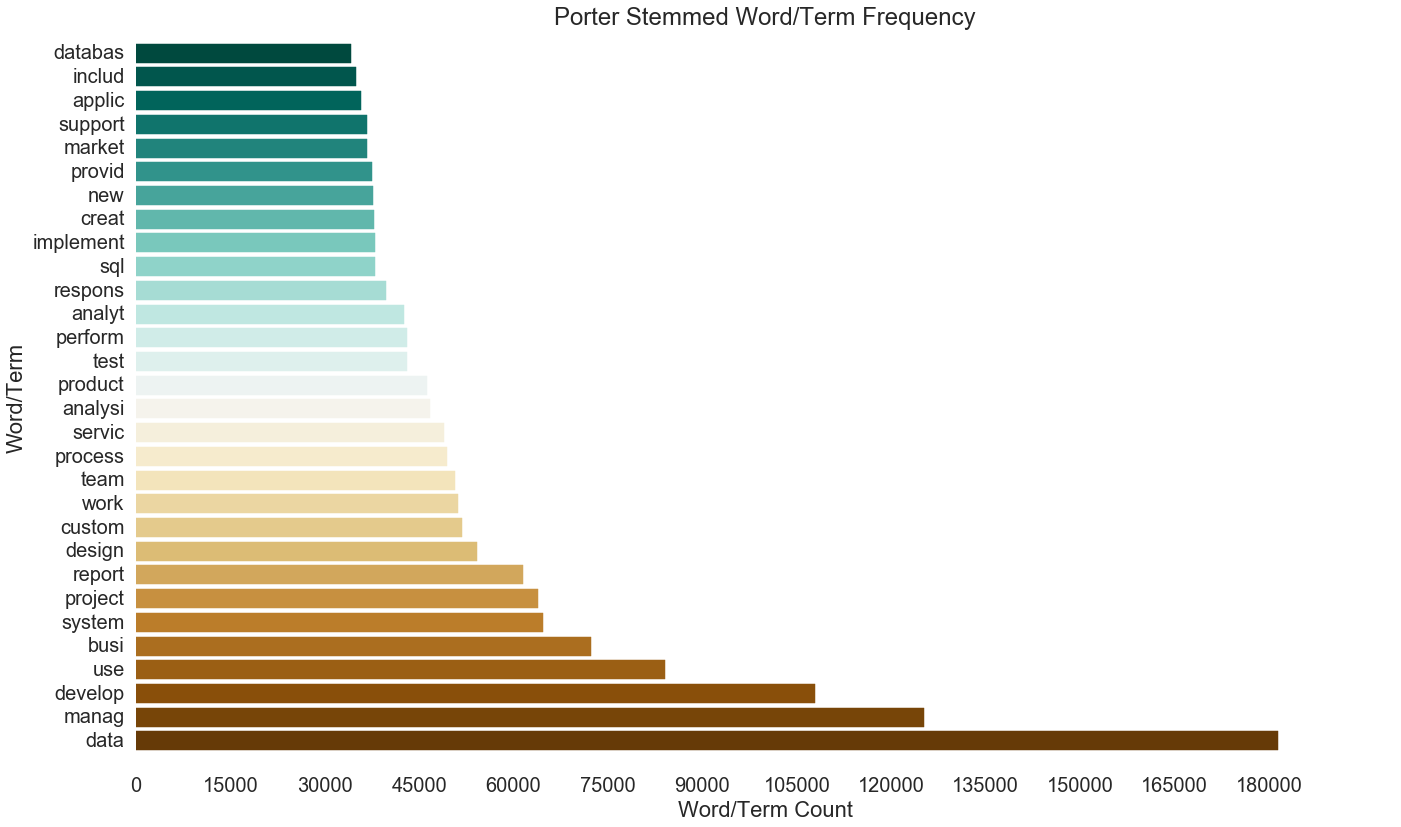

In [79]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

########## DATA ##############
lbl, ct = label_count(wordct_port_stem)
##############################

# color
colors = sns.color_palette("BrBG", len(lbl))

# plots
y_pos = np.arange(len(lbl))
ax.barh(y_pos, ct, align='center', color=colors, edgecolor=colors)

#plt.xlim(0,170000)
plt.ylim(-1,len(lbl))

# labels/titles
plt.legend(loc="best")
plt.title('Porter Stemmed Word/Term Frequency')
plt.xlabel('Word/Term Count')
plt.yticks(y_pos, lbl)
plt.ylabel('Word/Term')
plt.xticks(np.linspace(0,180000, 13))

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
#ax.xaxis.grid(True, alpha=0.2, linestyle='--') 
#ax.yaxis.grid(True, alpha=0.2, linestyle='--') 

# plot that biddy
plt.tight_layout()
_ = plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


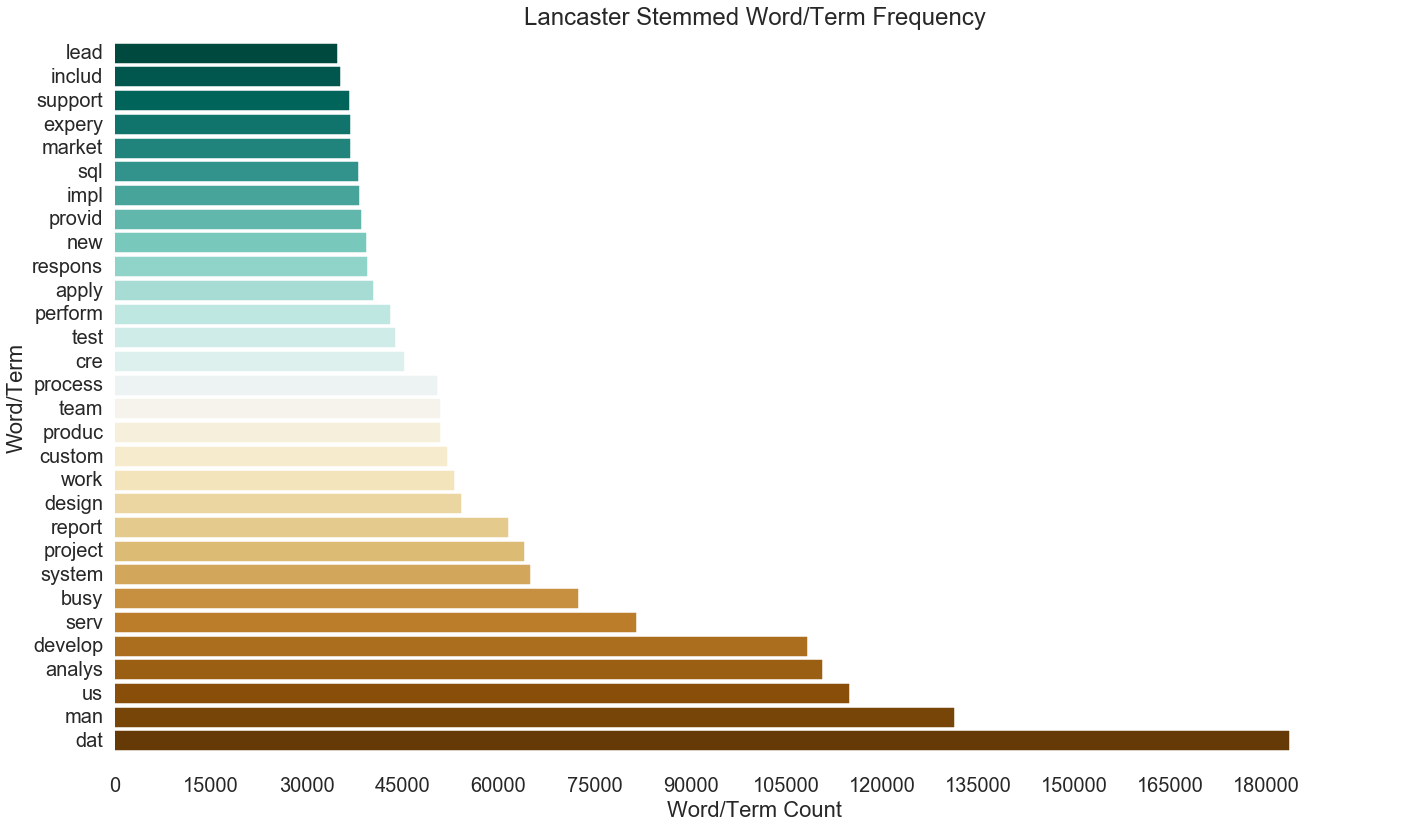

In [80]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

########## DATA ##############
lbl, ct = label_count(wordct_lanc_stem)
##############################

# color
colors = sns.color_palette("BrBG", len(lbl))

# plots
y_pos = np.arange(len(lbl))
ax.barh(y_pos, ct, align='center', color=colors, edgecolor=colors)

#plt.xlim(0,170000)
plt.ylim(-1,len(lbl))

# labels/titles
plt.legend(loc="best")
plt.title('Lancaster Stemmed Word/Term Frequency')
plt.xlabel('Word/Term Count')
plt.yticks(y_pos, lbl)
plt.ylabel('Word/Term')
plt.xticks(np.linspace(0,180000, 13))

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
#ax.xaxis.grid(True, alpha=0.2, linestyle='--') 
#ax.yaxis.grid(True, alpha=0.2, linestyle='--') 

# plot that biddy
plt.tight_layout()
_ = plt.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


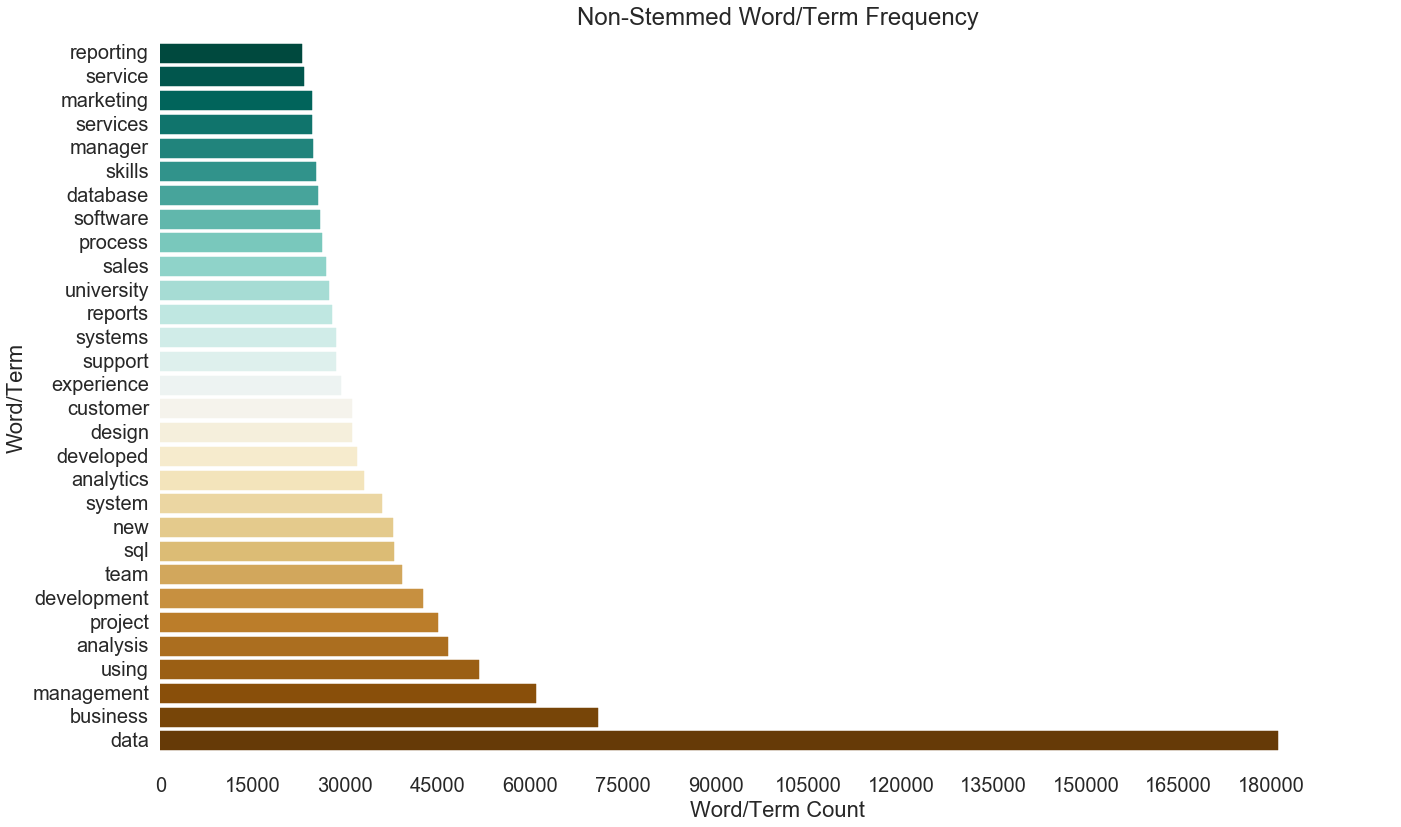

In [81]:
# make figure
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)

########## DATA ##############
lbl, ct = label_count(wordct)
##############################

# color
colors = sns.color_palette("BrBG", len(lbl))

# plots
y_pos = np.arange(len(lbl))
ax.barh(y_pos, ct, align='center', color=colors, edgecolor=colors)

#plt.xlim(0,170000)
plt.ylim(-1,len(lbl))

# labels/titles
plt.legend(loc="best")
plt.title('Non-Stemmed Word/Term Frequency')
plt.xlabel('Word/Term Count')
plt.yticks(y_pos, lbl)
plt.ylabel('Word/Term')
plt.xticks(np.linspace(0,180000, 13))

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
#ax.xaxis.grid(True, alpha=0.2, linestyle='--') 
#ax.yaxis.grid(True, alpha=0.2, linestyle='--') 

# plot that biddy
plt.tight_layout()
_ = plt.show()

# Nouns

In [33]:
#lst = ' '.join(lanc_stem[:1000])
lst = text[:10000]
#nouns = TextBlob(lst).noun_phrases

In [ ]:
text = df['resume_text'].tolist()
clean = df['resume_clean'].tolist()
stopped = df['resume_stopped'].tolist()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [ ]:
x_text = vectorizer.fit_transform(text)
print('Raw resume text number of features: {0}'.format(len(vectorizer.get_feature_names())))

In [ ]:
x_clean = vectorizer.fit_transform(clean)
print('Cleaned resume text number of features: {0}'.format(len(vectorizer.get_feature_names())))

In [ ]:
x_stop = vectorizer.fit_transform(stopped)
print('Stopped resume text number of features: {0}'.format(len(vectorizer.get_feature_names())))

In [ ]:
vectorizer = CountVectorizer(stopped, stop_words='english')
x_stop = vectorizer.fit_transform(stopped)
print('Stopped resume text number of features: {0}'.format(len(vectorizer.get_feature_names())))

In [ ]:
vect_stopped = vectorizer.get_feature_names()

stemmer = nltk.stem.porter.PorterStemmer()
stem_vect_stop = []
for i in vect_stopped:
    stem_vect_stop.append(stemmer.stem(i))

In [ ]:
len(set(stem_vect_stop))

# Stemmed

In [ ]:
from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()

In [ ]:
df['stem'] = df['resume_stopped'].apply(lambda x: stemmer.stem(x))
#df['stem'] = df['resume_stopped'].str.split(' ')

In [ ]:
df.head()

In [ ]:
# get wordcounts
wordcount = Counter(' '.join(df['resume_stopped']).split(' '))

# limit wordcounts for visualization
wordcount = wordcount.most_common(30)

In [ ]:
labels = [lbl for lbl, ct in wordcount]
count = [ct for lbl, ct in wordcount]

In [ ]:
# make figure
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

# color
colors = sns.color_palette("BrBG", len(labels))

# plots
y_pos = np.arange(len(labels))
ax.barh(y_pos, count, align='center', color=colors, edgecolor=colors)

#plt.xlim(0,170000)
plt.ylim(-1,30)

# labels/titles
plt.legend(loc="best")
plt.title('Word/Term Frequency')
plt.xlabel('Word/Term Count')
plt.yticks(y_pos, labels)
plt.ylabel('Word/Term')
plt.xticks(np.linspace(0,180000, 13))

# remove border
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.spines["left"].set_visible(False)

# show grid
#ax.xaxis.grid(True, alpha=0.2, linestyle='--') 
#ax.yaxis.grid(True, alpha=0.2, linestyle='--') 

# plot that biddy
plt.tight_layout()
_ = plt.show()

# Stemming

In [ ]:
fd = nltk.FreqDist(w.lower() for w in df['resume_stopped'])
#fd.plot(10)
fd

# N-Grams Count Vectorizer

In [ ]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

In [ ]:
t_start = time()

# convert resume texts to a sparse matrix of token counts
ct_vect = CountVectorizer(ngram_range=(1, 3), max_df=0.90, min_df=2, max_features=n_features, stop_words='english')
ct_vect_prep = ct_vect.fit_transform(df['resume_text'])

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

# Latent Dirichlet Allocation

In [ ]:
lda_mdl = LatentDirichletAllocation(n_topics=n_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0)

t_start = time()

lda_mdl.fit(ct_vect_prep)

print('Time to count vectorize data: {0:.4}s'.format(time() - t_start))

In [ ]:
print("Topics in LDA model:")

# get feature names (topics) from model
feat_names = ct_vect.get_feature_names()

print('Start of list: ' + ', '.join(feat_names[:20]))
print('End of list: ' + ', '.join(feat_names[-10:]))

# Get Top Words in Topics

In [ ]:
def print_top_words(model, feature_names, top_words):
    for i, topic in enumerate(model.components_):
        print("Topic {0}:".format(i))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print()

In [ ]:
print_top_words(lda_mdl, feat_names, 12)

# TF-IDF

In [ ]:
TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)[source]¶